In [1]:
import typing
import gc
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

import matplotlib.pyplot as plt

In [35]:
# synthetic_expression_data = pd.read_csv("data/net1_expression_data.tsv", sep='\t')
synthetic_expression_data = pd.read_csv("data/data-simulation/e-coli-500-node/merged.csv", index_col=0)

tfs = pd.read_csv("data/net1_transcription_factors.tsv", sep='\t')
random_tfs = pd.DataFrame(synthetic_expression_data.columns).sample(frac=.05)
tfs = random_tfs
X_bool = [g in tfs.iloc[:,0].tolist() for g in synthetic_expression_data.columns]
not_X = [not(e) for e in X_bool]
X_idx = [i for (i, e) in enumerate(X_bool) if e]

In [36]:
np.mean(synthetic_expression_data.iloc[:,5])

0.32551168846283185

In [37]:
# NORMALIZE
z_transform = StandardScaler(copy=False)
z_transform.fit_transform(synthetic_expression_data)

array([[ 0.04518885,  0.16374451,  0.62883995, ...,  0.05846342,
         0.2190241 ,  0.07647933],
       [-0.14144631, -0.15774705,  0.53108341, ...,  0.45463678,
         0.86524522, -0.32654599],
       [ 0.2762281 , -0.03694115,  0.54434669, ...,  0.51712831,
         0.40651447, -0.00949537],
       ...,
       [-2.46501206, -0.69810529, -0.84605715, ..., -0.20573043,
        -1.99335595, -1.33201507],
       [-1.78757682, -0.69810529,  0.79565111, ..., -1.18879434,
        -2.10641462,  2.06729139],
       [-1.78757682, -0.69810529, -1.95851045, ..., -1.84904187,
        -1.99335595, -1.33201507]])

In [38]:
np.mean(synthetic_expression_data.iloc[:,5])

7.478571118752115e-16

In [39]:
train, valid, test = (
    synthetic_expression_data.values[:500, :], 
    synthetic_expression_data.values[500:700, :],
    synthetic_expression_data.values[700:, :])

In [55]:
alphas = np.linspace(0.0001, 0.99, num=20)
valid_losses = []
for alpha in alphas:
    print("Computing validation loss for alpha = {}".format(alpha))
    lasso_model = Lasso(alpha).fit(train[:, X_bool], train)
    Y_hat = lasso_model.predict(valid[:, X_bool])
    valid_losses.append(mean_squared_error(Y_hat, valid))

Computing validation loss for alpha = 0.0001
Computing validation loss for alpha = 0.0522
Computing validation loss for alpha = 0.1043
Computing validation loss for alpha = 0.15639999999999998
Computing validation loss for alpha = 0.2085
Computing validation loss for alpha = 0.2606
Computing validation loss for alpha = 0.3127
Computing validation loss for alpha = 0.3648
Computing validation loss for alpha = 0.4169
Computing validation loss for alpha = 0.469
Computing validation loss for alpha = 0.5211
Computing validation loss for alpha = 0.5732
Computing validation loss for alpha = 0.6253
Computing validation loss for alpha = 0.6774
Computing validation loss for alpha = 0.7295
Computing validation loss for alpha = 0.7816
Computing validation loss for alpha = 0.8337
Computing validation loss for alpha = 0.8858
Computing validation loss for alpha = 0.9379
Computing validation loss for alpha = 0.99


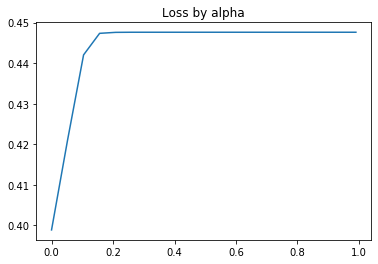

In [56]:
# plot losses
plt.plot(alphas, valid_losses)
plt.title("Loss by alpha")
plt.show()

In [57]:
lasso_model = Lasso(alphas[np.argmin(valid_losses)]).fit(train[:, X_bool], train)

Look at the model coefficients

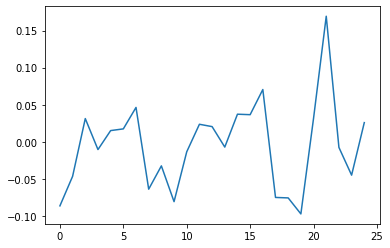

In [58]:
plt.plot(lasso_model.coef_[1])

In [59]:
Y_hat = lasso_model.predict(valid[:, X_bool])

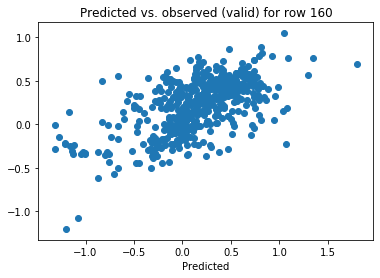

In [64]:
# plot predicted vs. observed for a random row
idx = np.random.randint(0, valid.shape[0])
plt.scatter(valid[idx], Y_hat[idx])
plt.xlabel("Observed")
plt.xlabel("Predicted")
plt.title("Predicted vs. observed (valid) for row {}".format(idx));

In [65]:
Y_hat = lasso_model.predict(test[:, X_bool])
print("Final test loss (mse): {}".format(mean_squared_error(Y_hat, test)))

Final test loss (mse): 1.2314798438696521


### Why is regularisation making performance poorer?
Is X compressible?

In [66]:
from sklearn.decomposition import PCA

In [67]:
pca_model = PCA().fit(train[:, X_bool])

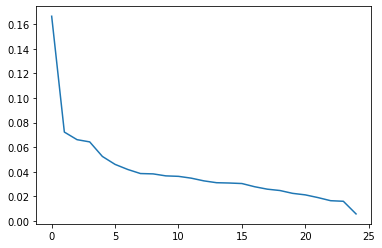

In [68]:
plt.plot(pca_model.explained_variance_ratio_)

In [69]:
# sanity check
sum(pca_model.explained_variance_ratio_)

0.9999999999999997

**Is all the information really in variable 0?**

In [70]:
lasso_model_2 = Lasso().fit(train[:, X_idx[0]].reshape(train.shape[0],1), train)

In [71]:
Y_hat = lasso_model_2.predict(valid[:, X_idx[0]].reshape(valid.shape[0],1))
print(mean_squared_error(Y_hat, valid))

0.44762601040550437


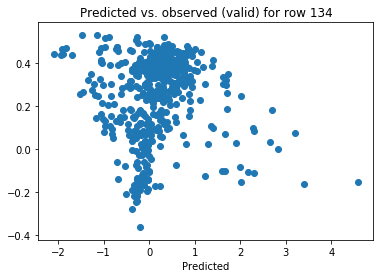

In [72]:
# plot predicted vs. observed for a random row
idx = np.random.randint(0, valid.shape[0])
plt.scatter(valid[idx], Y_hat[idx])
plt.xlabel("Observed")
plt.xlabel("Predicted")
plt.title("Predicted vs. observed (valid) for row {}".format(idx));

0.37156038784615125


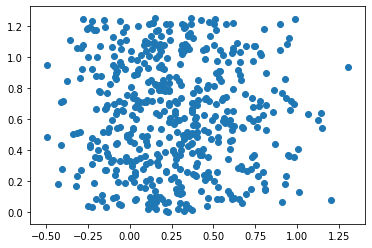

In [73]:
# what does random mse look like?
rand_pred = np.random.uniform(0, 1.25, size=valid.shape[1])
print(mean_squared_error(rand_pred, valid[0]))
plt.scatter(valid[0], rand_pred);

Let's try without variable 0

In [74]:
X_idx = X_idx[1:]

In [75]:
alphas = np.linspace(0.01, 0.25, num=20)
valid_losses = []
for alpha in alphas:
    print("Computing validation loss for alpha = {}".format(alpha))
    lasso_model = Lasso(alpha).fit(train[:, X_bool], train)
    Y_hat = lasso_model.predict(valid[:, X_bool])
    valid_losses.append(mean_squared_error(Y_hat, valid))

Computing validation loss for alpha = 0.01
Computing validation loss for alpha = 0.02263157894736842
Computing validation loss for alpha = 0.035263157894736843
Computing validation loss for alpha = 0.04789473684210526
Computing validation loss for alpha = 0.060526315789473685
Computing validation loss for alpha = 0.0731578947368421
Computing validation loss for alpha = 0.08578947368421051
Computing validation loss for alpha = 0.09842105263157894
Computing validation loss for alpha = 0.11105263157894736
Computing validation loss for alpha = 0.12368421052631579
Computing validation loss for alpha = 0.13631578947368422
Computing validation loss for alpha = 0.14894736842105263
Computing validation loss for alpha = 0.16157894736842104
Computing validation loss for alpha = 0.17421052631578948
Computing validation loss for alpha = 0.1868421052631579
Computing validation loss for alpha = 0.19947368421052633
Computing validation loss for alpha = 0.21210526315789474
Computing validation loss for

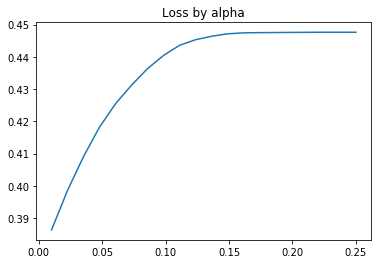

In [76]:
# plot losses
plt.plot(alphas, valid_losses)
plt.title("Loss by alpha")
plt.show()

In [77]:
print("Create a lasso model using alpha = {}".format(alphas[np.argmin(valid_losses)]))
lasso_model = Lasso(alphas[np.argmin(valid_losses)]).fit(train[:, X_idx], train)

Create a lasso model using alpha = 0.01


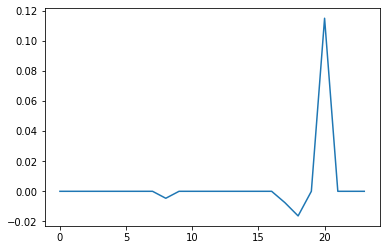

In [78]:
plt.plot(lasso_model.coef_[1])

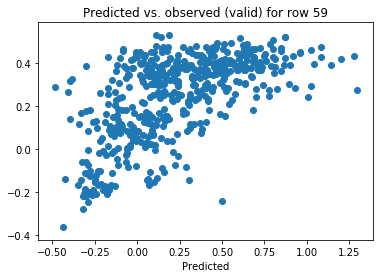

In [79]:
# plot predicted vs. observed for a random row
idx = np.random.randint(0, valid.shape[0])
plt.scatter(valid[idx], Y_hat[idx])
plt.xlabel("Observed")
plt.xlabel("Predicted")
plt.title("Predicted vs. observed (valid) for row {}".format(idx));

### Validation error

In [80]:
Y_hat = lasso_model.predict(valid[:, X_idx])
print(mean_squared_error(Y_hat, valid))

0.3866245427492607


### Test error

In [81]:
Y_hat = lasso_model.predict(test[:, X_idx])
print(mean_squared_error(Y_hat, test))

1.1772861290686911


### Let's try excluding the inputs from the outputs 

In [ ]:
alphas = np.linspace(0.001, 0.06, num=20)
valid_losses = []
for alpha in alphas:
    print("Computing validation loss for alpha = {}".format(alpha))
    lasso_model = Lasso(alpha).fit(train[:, X_idx], train[:, not_X])
    Y_hat = lasso_model.predict(valid[:, X_idx])
    valid_losses.append(mean_squared_error(Y_hat, valid[:, not_X]))

In [ ]:
# plot losses
plt.plot(alphas, valid_losses)
plt.title("Loss by alpha")
plt.show()

In [ ]:
print("Create a lasso model using alpha = {}".format(alphas[np.argmin(valid_losses)]))
lasso_model = Lasso(alphas[np.argmin(valid_losses)]).fit(train[:, X_idx], train)

In [ ]:
plt.plot(lasso_model.coef_[1])

In [ ]:
Y_hat = lasso_model_2.predict(valid[:, X_idx[0]].reshape(valid.shape[0],1))
print(mean_squared_error(Y_hat, valid))
plt.scatter(valid[3], Y_hat[3]);

### Is Y compressible?

In [58]:
pca_model = PCA().fit(train)

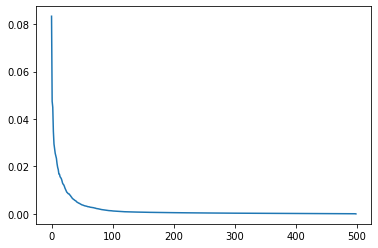

In [59]:
plt.plot(pca_model.explained_variance_ratio_)

In [60]:
# sanity check
sum(pca_model.explained_variance_ratio_)

0.9999999999999984